In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/

/content/drive/MyDrive


In [3]:
%%capture
!pip install evaluate
!pip install accelerate -U

In [17]:
import transformers
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, Trainer, TrainingArguments
import evaluate
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader

import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import json

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [48]:
class BERTFinetuner:
    """
    A class for fine-tuning the BERT model on a movie genre classification task.
    """

    def __init__(self, file_path, top_n_genres=5):
        """
        Initialize the BERTFinetuner class.

        Args:
            file_path (str): The path to the JSON file containing the dataset.
            top_n_genres (int): The number of top genres to consider.
        """
        self.file_path = file_path
        self.top_n_genres = top_n_genres

        self.accuracy = evaluate.load('accuracy')
        self.precision = evaluate.load('precision')
        self.recall = evaluate.load('recall')
        self.f1 = evaluate.load('f1')

    def load_dataset(self):
        """
        Load the dataset from the JSON file.
        """
        with open('IMDB_crawled.json', 'r') as f:
          self.data = json.loads(f.read())
          f.close()


    def preprocess_genre_distribution(self):
        """
        Preprocess the dataset by filtering for the top n genres
        """
        genres = {}
        num_movie_genres = 0

        for movie in self.data:
          if len(movie['genres']) > 0:
            num_movie_genres += 1
            g = movie['genres'][0]
            if g in genres:
              genres[g] += 1
            else:
              genres[g] = 1

        sorted_results = sorted(genres.items(), key = lambda x: (x[1], x[0]), reverse = True)
        genres = [x[0] for x in sorted_results]
        freqs = [x[1] for x in sorted_results]

        plt.bar(genres, freqs, color = 'red')
        plt.xlabel('genres')
        plt.ylabel('frequency')
        plt.title('genres distributions visualization')
        plt.xticks(range(len(genres)), genres, rotation='vertical')
        plt.show()

    def split_dataset(self, sentences, labels, test_size=0.2, val_size=0.5):
        """
        Split the dataset into train, validation, and test sets.

        Args:
            test_size (float): The proportion of the dataset to include in the test split.
            val_size (float): The proportion of the dataset to include in the validation split.
        """
        train_txt, test_txt, train_label, test_label = train_test_split(sentences, labels, test_size = test_size, random_state = 42)
        val_txt, test_txt, val_label, test_label = train_test_split(test_txt, test_label, test_size = val_size, random_state = 42)

        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

        train_encodings = self.tokenizer(train_txt, truncation=True, padding=True)
        val_encodings = self.tokenizer(val_txt, truncation=True, padding=True)
        test_encodings = self.tokenizer(test_txt, truncation=True, padding=True)

        self.train_dataset = IMDbDataset(train_encodings, train_label)
        self.val_dataset = IMDbDataset(val_encodings, val_label)
        self.test_dataset = IMDbDataset(test_encodings, test_label)

        return self.train_dataset, self.val_dataset, self.test_dataset



    def create_dataset(self):
        """
        Create a PyTorch dataset from the given encodings and labels.

        Args:
            encodings (dict): The tokenized input encodings.
            labels (list): The corresponding labels.

        Returns:
            IMDbDataset: A PyTorch dataset object.
        """
        sentences = []
        labels = []

        for movie in self.data:
          if len(movie['genres']) > 0 and movie['first_page_summary'] is not None:
            g = movie['genres'][0]
            summary = movie['first_page_summary']

            if g == 'Drama' or g == 'Romance':
              labels.append(0)
              sentences.append(summary)
            elif g == 'Action' or g == 'Thriller':
              labels.append(1)
              sentences.append(summary)
            elif g == 'Comedy':
              labels.append(2)
              sentences.append(summary)
            elif g == 'Animation':
              labels.append(3)
              sentences.append(summary)
            elif g == 'Crime':
              labels.append(4)
              sentences.append(summary)
            else:
              pass

        return self.split_dataset(sentences, labels)


    def fine_tune_bert(self, epochs=5, batch_size=16, warmup_steps=500, weight_decay=0.01):
        """
        Fine-tune the BERT model on the training data.

        Args:
            epochs (int): The number of training epochs.
            batch_size (int): The batch size for training.
            warmup_steps (int): The number of warmup steps for the learning rate scheduler.
            weight_decay (float): The strength of weight decay regularization.
        """
        training_args = TrainingArguments(
            output_dir='./results',
            num_train_epochs=epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=64,
            warmup_steps=warmup_steps,
            weight_decay=weight_decay,
            logging_dir='./logs',
            logging_steps=10,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            )
        self.model = BertForSequenceClassification.from_pretrained(
            "bert-base-uncased",
            num_labels = 5,

            output_attentions = False,
            output_hidden_states = False,
            )

        self.model.cuda()

        self.trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=self.train_dataset,
            eval_dataset=self.val_dataset,
            compute_metrics=self.compute_metrics,
        )

        self.trainer.train()


    def compute_metrics(self, pred):
        """
        Compute evaluation metrics based on the predictions.

        Args:
            pred (EvalPrediction): The model's predictions.

        Returns:
            dict: A dictionary containing the computed metrics.
        """
        predictions, labels = pred
        predictions = np.argmax(predictions, axis=1)
        result = {'accuracy': self.accuracy.compute(predictions=predictions, references=labels)['accuracy'],
              'precision': self.precision.compute(predictions=predictions, references=labels, average = 'macro')['precision'],
              'recall': self.recall.compute(predictions=predictions, references=labels, average = 'macro')['recall'],
              'f1': self.f1.compute(predictions=predictions, references=labels, average = 'macro')['f1']}
        return result

    def evaluate_model(self):
        """
        Evaluate the fine-tuned model on the test set.
        """
        print(self.trainer.evaluate(self.test_dataset))

    def save_model(self, model_name):
        """
        Save the fine-tuned model and tokenizer to the Hugging Face Hub.

        Args:
            model_name (str): The name of the model on the Hugging Face Hub.
        """
        repo_name = f'hajimr80/{model_name}'
        self.tokenizer.push_to_hub(repo_name)
        self.model.push_to_hub(repo_name)

class IMDbDataset(torch.utils.data.Dataset):
    """
    A PyTorch dataset for the movie genre classification task.
    """

    def __init__(self, encodings, labels):
        """
        Initialize the IMDbDataset class.

        Args:
            encodings (dict): The tokenized input encodings.
            labels (list): The corresponding labels.
        """
        # TODO: Implement initialization logic

        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Get a single item from the dataset.

        Args:
            idx (int): The index of the item to retrieve.

        Returns:
            dict: A dictionary containing the input encodings and labels.
        """
        # TODO: Implement item retrieval logic
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Get the length of the dataset.

        Returns:
            int: The number of items in the dataset.
        """
        # TODO: Implement length computation logic
        return len(self.labels)

In [57]:
# Instantiate the class
bert_finetuner = BERTFinetuner('IMDB_crawled.json', top_n_genres=5)

In [58]:
# Load the dataset
bert_finetuner.load_dataset()

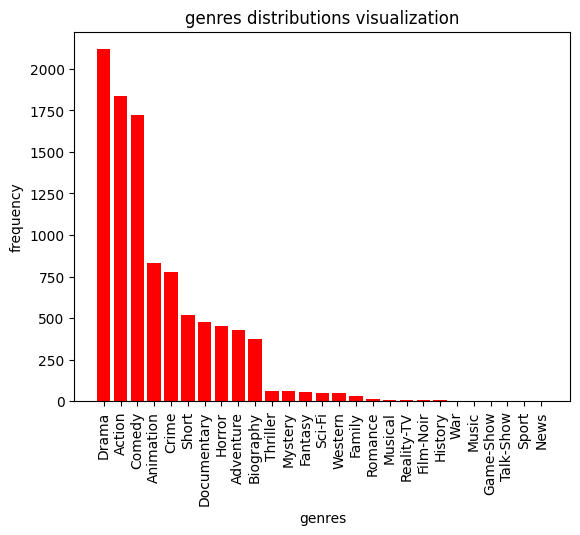

In [59]:
# Preprocess genre distribution
bert_finetuner.preprocess_genre_distribution()

In [60]:
# Create the dataset
train_dataset, val_dataset, test_dataset = bert_finetuner.create_dataset()

In [61]:
# Fine-tune BERT model
bert_finetuner.fine_tune_bert()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.160500,1.033058,0.601648,0.607337,0.606787,0.599071
2,0.945000,1.001305,0.575549,0.583849,0.590049,0.571092
3,0.611800,1.110325,0.614011,0.619124,0.612928,0.613277
4,0.233800,1.571757,0.593407,0.600790,0.575812,0.582488
5,0.073800,1.818010,0.612637,0.614760,0.599272,0.605487


In [62]:
# Compute metrics
bert_finetuner.evaluate_model()

{'eval_loss': 1.035944938659668, 'eval_accuracy': 0.5975274725274725, 'eval_precision': 0.6124644234310725, 'eval_recall': 0.5876858824722931, 'eval_f1': 0.5839109508114854, 'eval_runtime': 2.392, 'eval_samples_per_second': 304.35, 'eval_steps_per_second': 5.017, 'epoch': 5.0}


In [44]:
! huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [63]:
# Save the model (optional)
bert_finetuner.save_model('Movie_Genre_Classifier_v2')

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]